In [51]:
from final_2016 import pass_data
from graph_util import *

In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import expit
from torch import cholesky

import torch

import pyro
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot
from statsmodels.graphics.regressionplots import abline_plot

from collections import defaultdict
import seaborn as sns

import plotnine as p9
from plotnine import *
from tqdm.notebook import tqdm

import dill

## Goals

Our goals are two-fold:
  1. is to translate The Economist's presidential election prediction model from R & Stan to Python & Pyro
  2. is to do a thorough evaluation of the results generated by the model and inference methods we have translated from the previous goal

## Model

The model that we have translated is a Dynamic Bayesian Model which is a bayesian network that relates the latent variables amongst themselves over adjacent time steps. The model has a backward component categorized by $y^d_i \sim \text{Binom}(n_i, \pi^d_{i,j})$, where $y^d_i$ is the number of voters in favor of a democrat, $n_i$ is the number of voters reporting a party preference, and $\pi^d_{i,j}$ is the share who would vote for democratic candidate on day $j$. The prior is $\pi^d_{i,j} = \text{logit}^{-1}(\beta_{i,j} + \delta_j)$ where $\beta_{i,j}$ is the state level effect and $\delta_j$ is the national level effect with priors defined on both of these R.V. as well. 

#### Abramovitz "Time for Change" Model

national_mu_prior = $x_0 + x_1 \cdot \text{juneapp} + x_2 \cdot \text{q2gdp}$

In [3]:
data, polls, res, dfTemp, ev = pass_data()

                            OLS Regression Results                            
Dep. Variable:                incvote   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           1.62e-05
Time:                        22:47:52   Log-Likelihood:                -41.736
No. Observations:                  18   AIC:                             89.47
Df Residuals:                      15   BIC:                             92.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.6070      0.835     59.386      0.0

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18


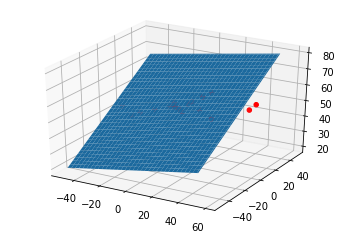

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfTemp['juneapp'], dfTemp['q2gdp'], dfTemp['incvote'], c='r', marker='o')

coefs = res.params
xs = np.tile(np.arange(101), (101,1)) - 50
ys = np.tile(np.arange(101), (101,1)).T - 50
national_mu_prior =  coefs["Intercept"] + coefs["juneapp"] * xs + coefs["q2gdp"] * ys

ax.plot_surface(xs,ys,national_mu_prior)
plt.show()

### Dynamic Bayesian Model w. Polling & Abramovitz Data

In [5]:
from poll_model import model, Inference_MCMC, sample_posterior_predictive

In [6]:
def predicted_score(posterior_predictive, num_samples):
    N = num_samples # Number of samples extracted from posterior
    T = data['T'] # Number of days
    S = data['S'] # Number of states
    predicted = torch.empty(N, T, S)
    mu_b = posterior_predictive["mu_b"].squeeze()
    for s in range(S):
        predicted[:,:,s] = expit(mu_b[:,s,:])

    return predicted

### Inference

Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model. We use the NUTs paradigm to help explore our vast data set in a more efficient manner; otherwise we would not be able to tractably estimate the posterior. 

In [7]:
numSamples = 100
numChains = 6

In [8]:
posterior_samples, hmc_samples = Inference_MCMC(model, data,
                                                polls, numSamples,
                                                numSamples, numChains)

### Posterior Predictive

This gives us the samples that are conditioned on the posterior distribution of the latent variable model so that we can extract the predicted variables such as mu_b and thereafter evaluate the model.

In [9]:
posterior_predictive = sample_posterior_predictive(model,
                                                   posterior_samples,
                                                   numSamples*numChains, data)

### Predicted Probability

In [10]:
predicted = predicted_score(posterior_predictive, numSamples*numChains)

In [79]:
vals = predicted[:,90,:]

In [80]:
preds = createPredictionsDict(vals)

In [81]:
swing_states = ["OH", "WI", "MI", "FL", "GA", "PA", "IA", "AZ"]
EV, EV_Index = ev["EV"], ev["EV_Index"]
numDays = len(preds[0])
numStates = len(preds)
EV_list_trump = list()
EV_list_clinton = list()


out = electoralVoteCalculator(numDays, numStates,
                        preds, EV_Index, EV)
cWins, tWins, EV_T, EV_C = out[0], out[1], out[2], out[3]

In [82]:
ind_list = [list(EV.keys()).index(s) for s in swing_states]

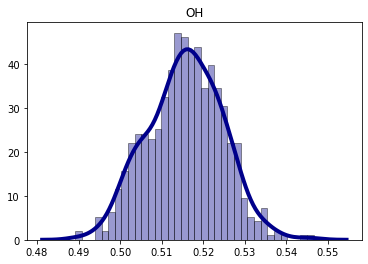

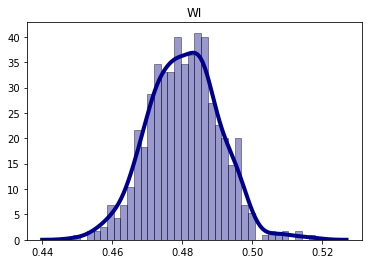

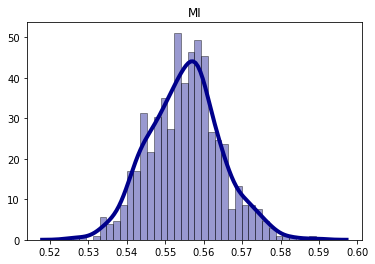

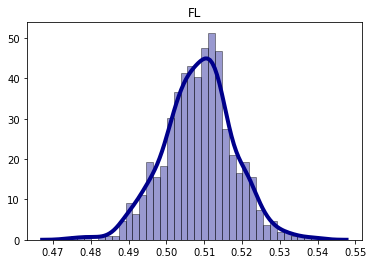

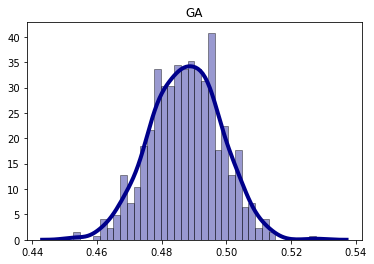

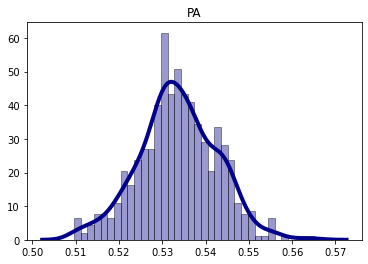

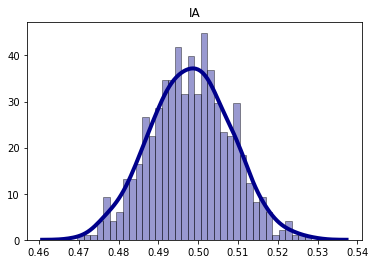

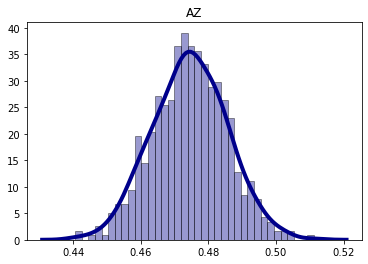

In [83]:
for i in ind_list:
    plt.figure()
    sns.distplot(preds[i], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title(EV_Index[i])

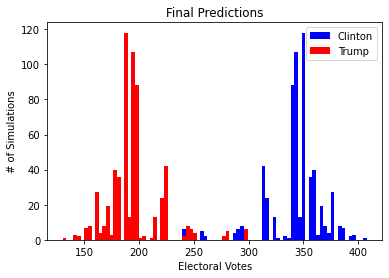

In [84]:
plt.hist(EV_C, bins='auto', color = 'b')
plt.hist(EV_T, bins='auto', color = 'r')
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Electoral Votes")
plt.ylabel("# of Simulations")
plt.title("Final Predictions")
plt.show()

In [108]:
cWinsList, tWinsList = [], []
EV_C_mu, EV_T_mu = [], []
EV_C_std, EV_T_std = [], []

for i in tqdm(range(252)):
    vals = predicted[:,i,:]
    pred = createPredictionsDict(vals)
    out = electoralVoteCalculator(numDays, numStates,
                        pred, EV_Index, EV)
    cWins, tWins, EV_T, EV_C = out[0], out[1], out[2], out[3]
    cWinsList.append(cWins)
    tWinsList.append(tWins)
    
    mu_C, mu_T = average(EV_C), average(EV_T)
    std_C, std_T = std(EV_C, mu_C), std(EV_T, mu_T)
    
    EV_C_mu.append(mu_C)
    EV_C_std.append(std_C)
    
    EV_T_mu.append(mu_T)
    EV_T_std.append(std_T)

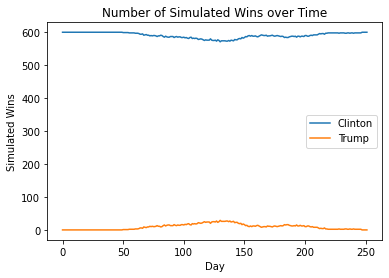

In [116]:
sns.lineplot(data=np.array(cWinsList))
sns.lineplot(data=np.array(tWinsList))
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Day")
plt.ylabel("Simulated Wins")
plt.title("Number of Simulated Wins over Time")
plt.show()

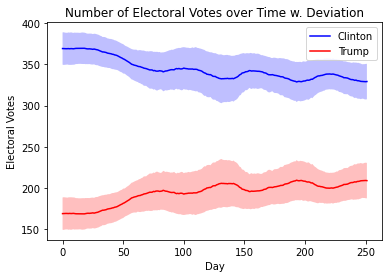

In [136]:
upper_C = [x + y for x,y in zip(EV_C_mu, EV_C_std)]
lower_C = [x - y for x,y in zip(EV_C_mu, EV_C_std)]

upper_T = [x + y for x,y in zip(EV_T_mu, EV_T_std)]
lower_T = [x - y for x,y in zip(EV_T_mu, EV_T_std)]

sns.lineplot(data=np.array(EV_C_mu), color="blue")
sns.lineplot(data=np.array(EV_T_mu), color="red")
plt.fill_between(range(len(EV_C_mu)), upper_C, lower_C, facecolor="blue", alpha=0.25)
plt.fill_between(range(len(EV_T_mu)), upper_T, lower_T, facecolor="red", alpha=0.25)
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Day")
plt.ylabel("Electoral Votes")
plt.title("Number of Electoral Votes over Time w. Deviation")
plt.show()

In [94]:
def mean_low_high(draws, states, Id): 
    mean = expit(draws.mean(axis=0))
    high = expit(draws.mean(axis=0) + 1.96* draws.std(axis = 0))
    low = expit(draws.mean(axis=0) - 1.96* draws.std(axis = 0))
    Id = [Id]*len(states)
    draws_df = {'states': states ,'mean': mean, 'high': high, 'low': low, 'type': Id}
    draws_df = pd.DataFrame(draws_df)
    
    return draws_df

In [95]:
states = list(EV.keys())

In [96]:
mu_b_prior = data['mu_b_prior']
state_covariance_mu_b_T = data['state_covariance_mu_b_T']
mu_b_prior_draws = np.random.multivariate_normal(mu_b_prior, state_covariance_mu_b_T, 1000)
mu_b_prior_df = mean_low_high(mu_b_prior_draws, states, 'prior')

In [97]:
mu_b_posterior_draws = posterior_predictive['mu_b'].squeeze()[:,:,-1]
mu_b_posterior_df = mean_low_high(mu_b_posterior_draws, states, 'posterior')
mu_b_posterior_df['color'] = mu_b_posterior_df['mean']>0.5

idx = mu_b_posterior_df["states"].isin(swing_states)
mu_b_posterior_df[idx][['states', 'mean', 'high', 'low']]

,states,mean,high,low
2,AZ,0.459112,0.476626,0.441697
9,FL,0.504809,0.520862,0.488746
10,GA,0.478340,0.494622,0.462103
15,IA,0.492339,0.508820,0.475875
22,MI,0.545917,0.562156,0.529580
35,OH,0.504648,0.520809,0.488477
38,PA,0.530957,0.547512,0.514333
49,WI,0.482755,0.499422,0.466126


In [98]:
mu_b_df = pd.concat([mu_b_prior_df, mu_b_posterior_df])

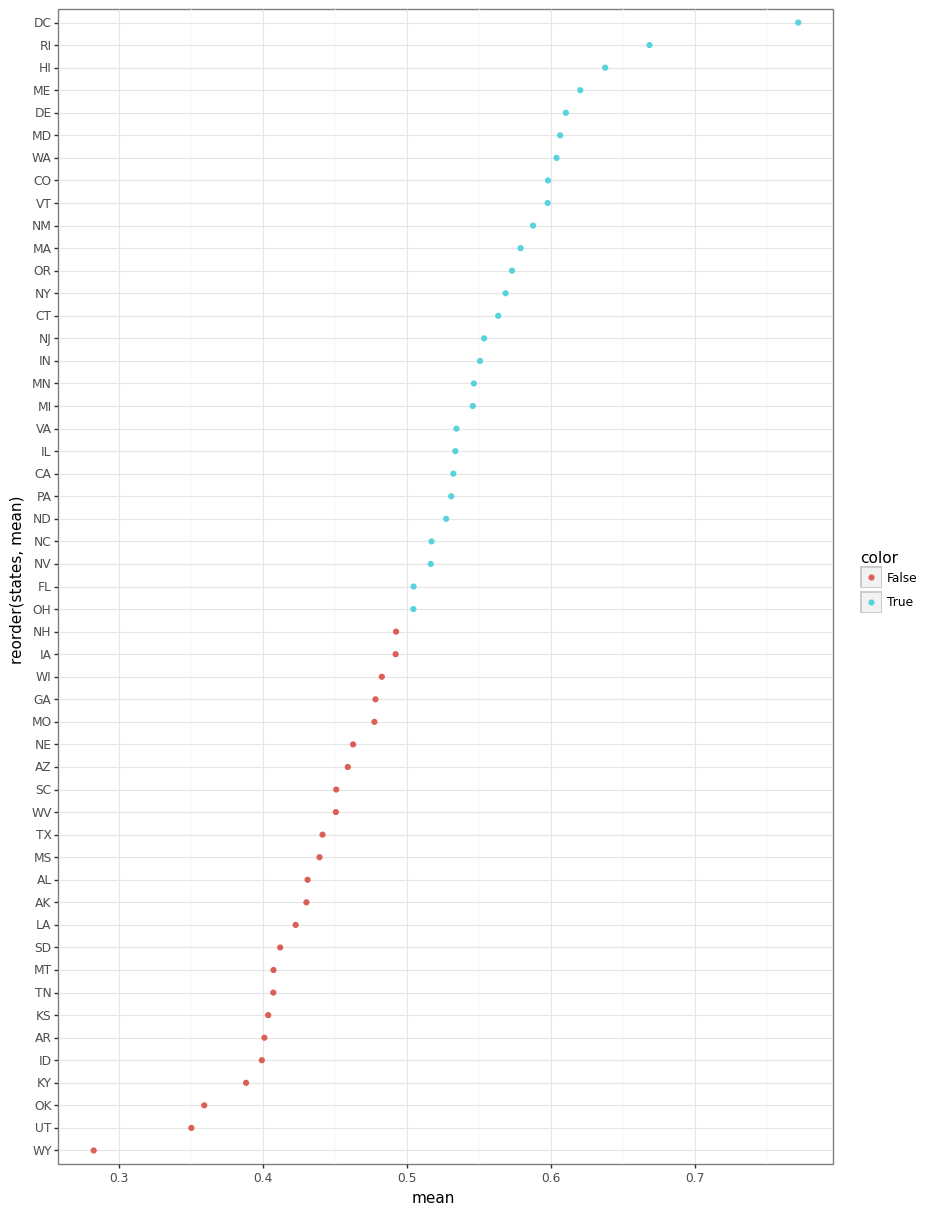

<ggplot: (324310056)>

In [99]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_posterior_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='color'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

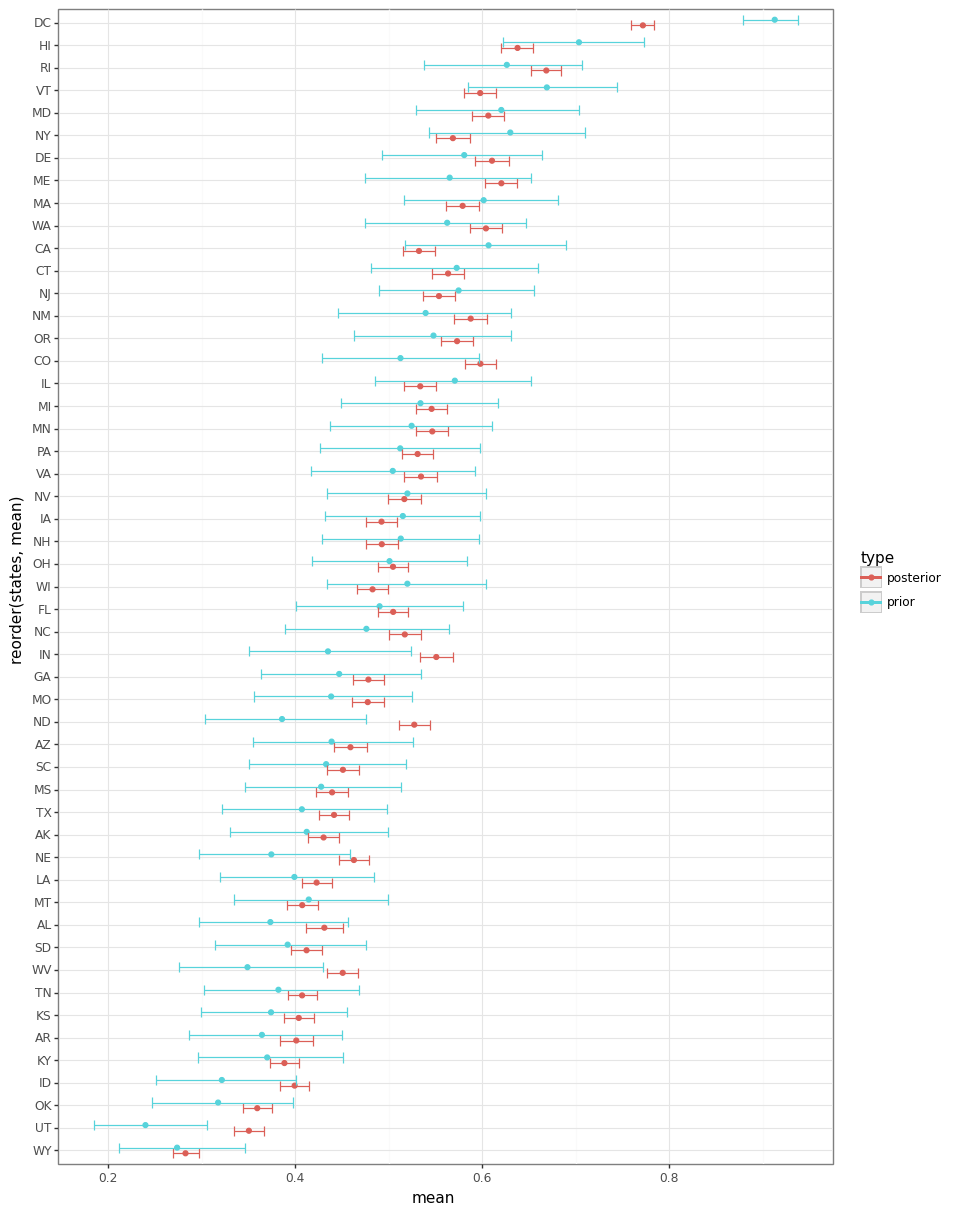

<ggplot: (324085770)>

In [100]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type'), position = position_dodge(width = 0.5)) +
    geom_errorbar(aes(ymin = 'low', ymax = 'high', x = 'states', color='type'), width = 0, position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

In [101]:
def function_tibble(x, predicted):
    temp = predicted[:,:,x]
    low = np.quantile(predicted[:,:,x], 0.025, axis=0)
    high = np.quantile(predicted[:,:,x], 0.975, axis=0)
    mean = torch.mean(predicted[:,:,x], axis = 0)
    prob = (predicted[:,:,x]>0.5).type(torch.float).mean(axis=0)
    state = [x]*temp.shape[1]
    t = np.arange(temp.shape[1])
    df = pd.DataFrame({'low':low, 'high':high, 'mean':mean, 'prob':prob, 'state': state, 't': t})
    return df

In [102]:
pct_clinton = function_tibble(0, predicted)
for i in range(1, predicted.shape[2]):
    temp = function_tibble(i, predicted)
    pct_clinton = pd.concat([pct_clinton, temp])
pct_clinton['state'] = pct_clinton['state'].apply(lambda x: states[x])

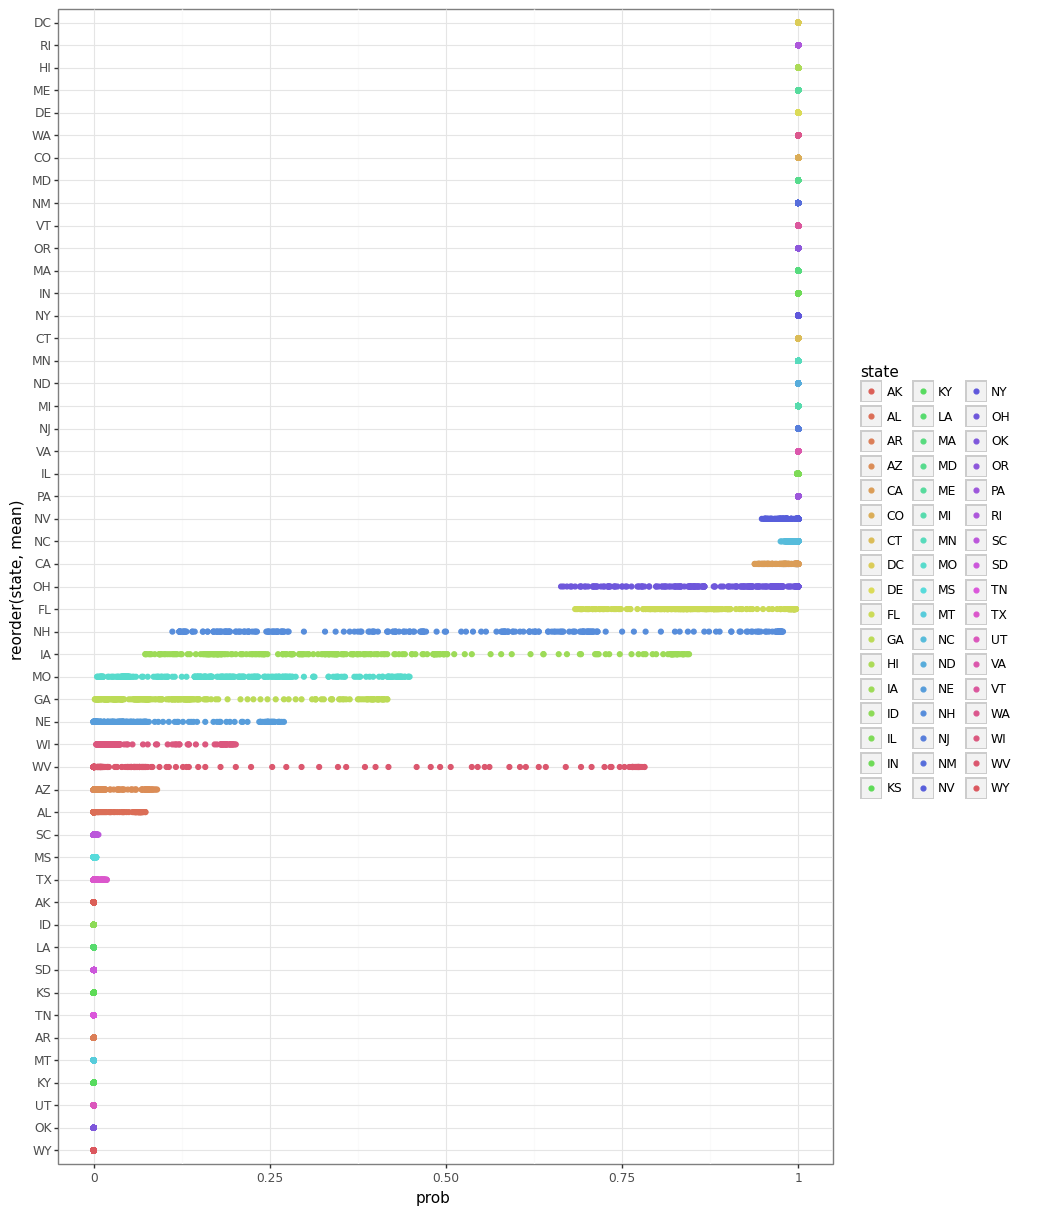

<ggplot: (332488078)>

In [103]:
p9.options.figure_size = (10, 15)
(
    ggplot(pct_clinton) +
    geom_point(aes(y = 'prob', x = 'reorder(state, mean)', color='state'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

In [104]:
cols = ['state', 'year', 'dem']
results = pd.read_csv("../data/potus_results_76_16.csv", usecols=cols)
results = results.loc[results['year'] == 2016][['state','dem']].reset_index().drop(columns=['index'])
results = results.rename(columns={'state': 'states', 'dem':'mean'})
results['type'] = ['result']*len(states)

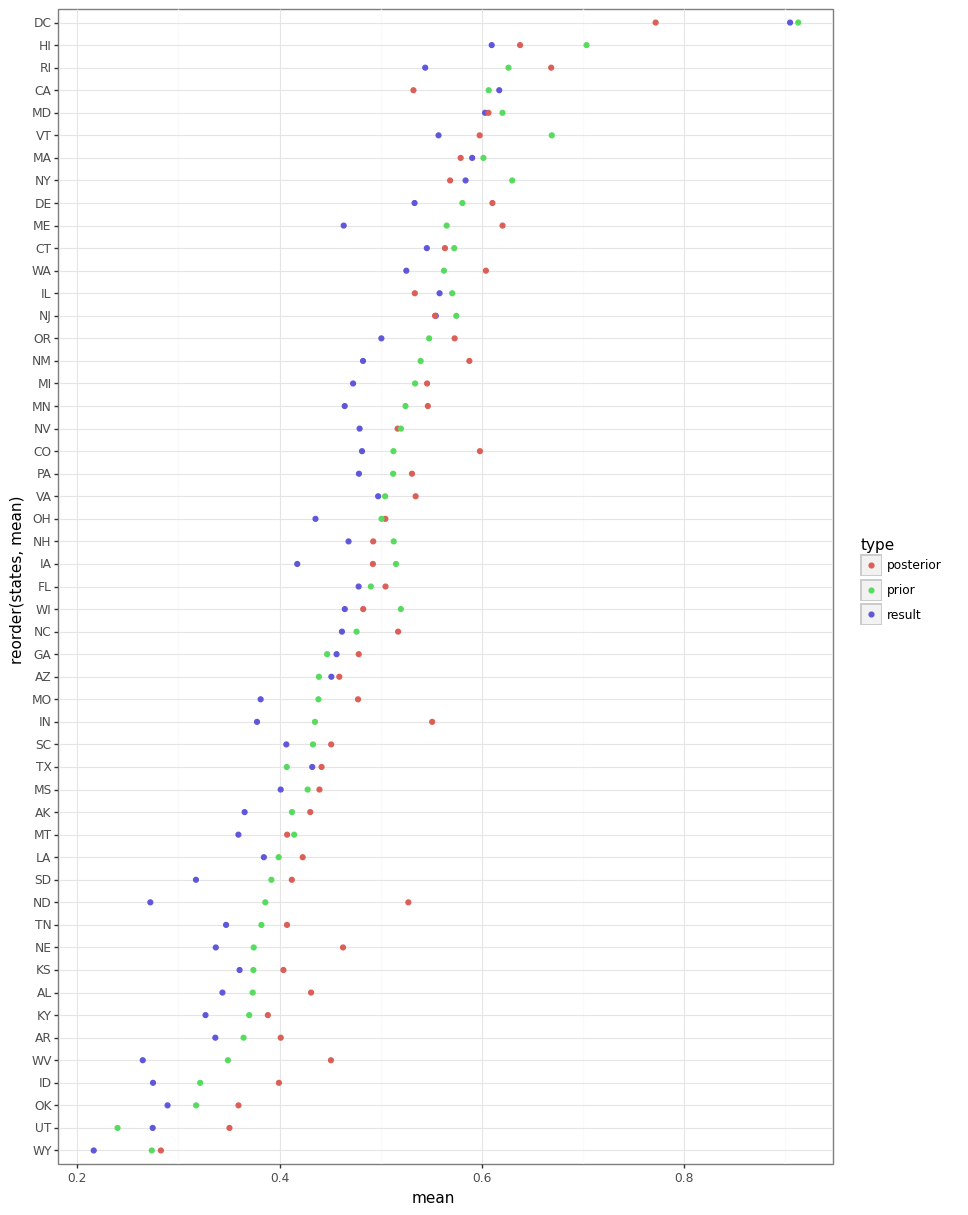

<ggplot: (337369637)>

In [105]:
p9.options.figure_size = (10, 15)
(
    ggplot(pd.concat([results, mu_b_posterior_df, mu_b_prior_df])) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type')) +
    coord_flip() +
    theme_bw()
 )